# Estimation Exercise:  Method of Simulated Moments (MSM) Estimation with respy

This guide contains an estimation exercise for the use of [respy](https://respy.readthedocs.io/en/latest/)'s method of simulated moments interface with [estimagic](https://estimagic.readthedocs.io/en/latest/)'s optimization capabilities.

A detailed guide to the MSM interface itself can be found [here](https://respy.readthedocs.io/en/latest/how_to_guides/msm.html), which provides a overview of respy's MSM functions and outlines how inputs maybe specified to construct a criterion function. This guide as a next step showcases a small estimation exercise to estimate parameters with the specified criterion function.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configure-MSM-inputs" data-toc-modified-id="Configure-MSM-inputs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configure MSM inputs</a></span><ul class="toc-item"><li><span><a href="#Model" data-toc-modified-id="Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Moment-&amp;-Replacement-Functions" data-toc-modified-id="Moment-&amp;-Replacement-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Moment &amp; Replacement Functions</a></span></li><li><span><a href="#Empirical-Moments" data-toc-modified-id="Empirical-Moments-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Empirical Moments</a></span></li><li><span><a href="#Weighting-Matrix" data-toc-modified-id="Weighting-Matrix-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Weighting Matrix</a></span></li><li><span><a href="#Criterion-Function" data-toc-modified-id="Criterion-Function-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Criterion Function</a></span></li></ul></li><li><span><a href="#Configure-optimization" data-toc-modified-id="Configure-optimization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Configure optimization</a></span><ul class="toc-item"><li><span><a href="#Add-bounds-to-parameters" data-toc-modified-id="Add-bounds-to-parameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Add bounds to parameters</a></span></li><li><span><a href="#Create-configuration-dictionary-for-optimization" data-toc-modified-id="Create-configuration-dictionary-for-optimization-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Create configuration dictionary for optimization</a></span></li><li><span><a href="#Logging" data-toc-modified-id="Logging-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Logging</a></span></li></ul></li><li><span><a href="#Estimation-Exercise" data-toc-modified-id="Estimation-Exercise-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Estimation Exercise</a></span><ul class="toc-item"><li><span><a href="#Show-Results" data-toc-modified-id="Show-Results-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Show Results</a></span></li><li><span><a href="#Difference-in-moments-result-&amp;-observed" data-toc-modified-id="Difference-in-moments-result-&amp;-observed-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Difference in moments result &amp; observed</a></span></li><li><span><a href="#Criterion-History" data-toc-modified-id="Criterion-History-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Criterion History</a></span></li></ul></li><li><span><a href="#Maximum-Likelihood" data-toc-modified-id="Maximum-Likelihood-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Maximum Likelihood</a></span></li></ul></div>

In [5]:
import os
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import respy as rp
from respy.method_of_simulated_moments import _harmonize_input
from estimagic.logging.create_database import load_database
from estimagic.logging.read_database import read_last_iterations
from estimagic import minimize

## Configure MSM inputs

To configure the MSM criterion function for estimation, we need to define a number of inputs. We will use respy's `kw_94_one` example model for the exercise. The following section will outline all the inputs needed to set up the estimation.

### Model

We can generate the model using respy `get_example_model` function. We will treat the parameter vector from this specification as the *true* parameter vector that we will try to retrieve during estimation. With it comes our *observed data* that is generated using the true parameters and which we will match simulated moments generated from candidate parameter vectors to. 

In [6]:
model = "robinson_crusoe_basic"

In [7]:
params, options, data_obs = rp.get_example_model(model)

To ease the workflow, we can collect all of the inputs needed for the method of simulated moments estimation in a nested dictionary. This is not necessary but makes it easier to pass all the elements on to different functions later on.

In [8]:
msm_inputs = {}
msm_inputs["params"], msm_inputs["options"] = params, options

### Moment & Replacement Functions

Aside from the parameters and options that are used to define the model, we need to define functions to compute moments and to replace missing moments for the simulated data we generate for parameter vector candidates during estimation.

In [9]:
# Functions
def calc_choice_frequencies(df):
    """Calculate choice frequencies"""
    return df.groupby("Period").Choice.value_counts(normalize=True).unstack()

def calc_wage_distribution(df):
    """Calculate wage distribution."""
    return df.groupby(["Period"])["Wage"].describe()[["mean", "std"]]

def replace_nans(df):
    """Replace missing values in data."""
    return df.fillna(0)

We save the arguments in dictionaries and pass them on to our overreaching nested dictionary `msm_inputs`.

In [10]:
msm_inputs["calc_moments"] = {
    "choice_frequencies": calc_choice_frequencies,
    "wage_distribution" : calc_wage_distribution
}

msm_inputs["replace_nans"] = {"replace_nans": replace_nans}

### Empirical Moments

Now that we have defined the functions needed to compute moments, we can use them to compute the empirical or observed moments for our data. 

In [11]:
msm_inputs["empirical_moments"] = {
    "choice_frequencies": replace_nans(calc_choice_frequencies(data_obs)),
    "wage_distribution" : replace_nans(calc_wage_distribution(data_obs)),
}

### Weighting Matrix

Additionally we compute a diagonal variance weighting matrix using a bootstrapping procedure using the function below.

In [12]:
def get_weighting_matrix(data, calc_moments, num_boot, sample_boot):
    """ Compute weighting matrix for estimation with MSM."""
    np.random.seed(123)

    # Turn calc_moments into list in case it's a dict or single function.
    calc_moments = _harmonize_input(calc_moments)

    index_base = data.index.get_level_values("Identifier").unique()

    moments_sample = list()
    for _ in range(num_boot):
        ids_boot = np.random.choice(index_base, sample_boot, replace=False)
        moments_boot = [func(data.loc[ids_boot, :]) for func in calc_moments]

        moments_boot = rp.get_flat_moments(moments_boot)

        moments_sample.append(moments_boot)

    moments_var = np.array(moments_sample).var(axis=0)
    weighting_matrix = np.diag(moments_var ** (-1))

    return np.nan_to_num(weighting_matrix)

In [13]:
msm_inputs["weighting_matrix"] = get_weighting_matrix(
    data=data_obs,
    calc_moments=msm_inputs["calc_moments"],
    num_boot=300,
    sample_boot=500
)

### Criterion Function

Now that we have specified all inputs, we can pass them on to respy's `get_msm_func` to generate the criterion function. So far, this guide has just repeated the steps outlined in the general [method of simulated moments](https://respy.readthedocs.io/en/latest/how_to_guides/msm.html) guide (with the exception of collecting the inputs in a nested dictionary and the choice of weighting matrix).

In [14]:
criterion_msm = rp.get_msm_func(**msm_inputs)

## Configure optimization

In the next step we address the elements that are needed for optimization of the criterion function. These specifications are undertaken specifically for estimation with estimagic. Other optimization packages might require different configurations. 

### Add bounds to parameters

In [15]:
def add_params_bounds(params, deviation):
    """ Add upper and lower bounds in parameter vector for optimization."""
    params = params.copy()
    params["lower"] = params["value"] - abs((params["value"] * deviation))
    params["upper"] = params["value"] + abs((params["value"] * deviation))
    params["upper"] = params["upper"].replace(0, deviation)
    
    params.loc[("delta","delta"),("lower", "upper")] = (0, 1)    
    params.loc["shocks_sdcorr", ("lower","upper")] = (-(np.inf), np.inf)
    
    return params

In [16]:
params = add_params_bounds(params, 0.05)

In [17]:
params

value   lower   upper
category                name                                          
delta                   delta                     0.95   0.000   1.000
wage_fishing            exp_fishing               0.10   0.095   0.105
nonpec_fishing          constant                 -1.00  -1.050  -0.950
nonpec_hammock          constant                  2.50   2.375   2.625
                        not_fishing_last_period  -1.00  -1.050  -0.950
shocks_sdcorr           sd_fishing                1.00    -inf     inf
                        sd_hammock                1.00    -inf     inf
                        corr_hammock_fishing     -0.20    -inf     inf
lagged_choice_1_hammock constant                  1.00   0.950   1.050
inadmissibility_penalty inadmissibility_penalty -20.00 -21.000 -19.000

### Create configuration dictionary for optimization

There are additional arguments we need to pass on to the optimizer like the optimization algorithm and  constraints. We can get the constraints for the selected model from respy using `get_parameter_constraints`. 

In [18]:
optim_config = {
    "algorithm": "nlopt_bobyqa",
    "constraints": rp.get_parameter_constraints(model)
    + [{"loc": "inadmissibility_penalty", "type": "fixed"}],
}

### Logging

Estimagic creates a database file for each optimization it conducts. The database file contains useful information about the optimization process like the criterion and parameter values at each iteration. In order to save the databases for each optimization and prevent them from being overwritten when a new optimization is launched, we can define a function that creates a logging path based on the current date and time to ensure a unique logging path for each optimization.

In [19]:
def create_logging_path(target_dir):
    """
    Creates a directory in the target_dir based on current
    date and time.
    """
    cwd = os.path.abspath(os.getcwd())
    directory = cwd + target_dir
    if not os.path.exists(directory):
        os.mkdir(directory)
    time = datetime.now().strftime("%d.%m.%Y_%H-%M-%S")
    logging_path = directory + "/" + time
    os.mkdir(logging_path)
    return logging_path

In [20]:
logging_path = create_logging_path("/logging/")

## Estimation Exercise

Finally, we can perform the estimation exercise. The target of this exercise is to test whether an optimizer manages to retrieve the true parameter vector (approximately) after we have induced it to distance itself from the true vector. To generate start values for the estimation that differ from the true vector, we misspecify the model by fixing the discount factor to 0 and trying to estimate the parameters. Within the bounds specified above, the estimated values will diverge from the true ones. In the second step, delta is fixed back to the correct value and the resulting parameter vector is used as the starting values for the new estimation. During this estimation, the simulated moments should converge back to the observed ones. 

In short, the exercise comprises the following steps.

1. Begin with the true parameter vector `params_true`, set delta to 0, and fix it in the constraints, 
thereby misspecifying the model.
2. Estimate the free parameters for the misspecified model for a selected number of maximum evaluations of
the criterion function.
3. Using the resulting parameter vector from (2) as start values, set delta back to it's true value 
and estimate again.

In [21]:
def delta_exercise(
        params_true,
        criterion,
        optim_config,
        logging_path,
        eval_away,
        eval_back,
):
    configuration = copy.deepcopy(optim_config)

    # 1. Fix delta to 0 in the parameter vector.
    start_away = params_true.copy()
    start_away.loc["delta", "value"] = 0
    
    configuration["constraints"] += [{"loc": "delta", "type": "fixed"}]
    configuration["algo_options"] = {"maxeval": eval_away}
    
    # 2. Run optimization with misspecified model.
    rslt_away = minimize(
        criterion,
        params=start_away,
        logging=logging_path + "/logging_away.db",
        **configuration
    )

    # 3. Set delta back to true value and estimate again.
    start_back = rslt_away[1][["value"]].copy()
    start_back.loc["delta", "value"] = params_true.loc[("delta","delta"), "value"]
    configuration["algo_options"] = {"maxeval": eval_back}

    rslt_back = minimize(
        criterion,
        params=start_back,
        logging=logging_path + "/logging_back.db",
        **configuration
    )

    # 4. Save results.
    params_dict = {
        
        "start_away_delta_zero": start_away,
        "rslt_away": rslt_away[1],
        "start_back_true_delta": start_back,
        "rslt_back": rslt_back[1],
        
                   }
    
    return params_dict

We use the function above to perform the exercise. The function returns a dictionary with the parameter vector at different steps in the exercise. Additionally, the optimizations are monitored in the databases `logging_away.db` and `logging_back.db` for step (2) and step (3) respectively and saved to a logging path based on the current date and time at the beginning of the exercise.

In [22]:
 params_dict = delta_exercise(
                                params_true=params,
                                criterion=criterion_msm,
                                optim_config=optim_config,
                                logging_path=logging_path,
                                eval_away=100,
                                eval_back=100,
                            )

### Show Results

We can visualize the results using the parameter dictionary we returned from the exercise and the logging databases. Instead of looking at the parameter values directly, we are more interested in how well they manage to predict the moments we selected for estimation, especially the choices of individuals in each period. We thus compute the moments for all parameter vectors that were saved to `params_dict`. 

In [23]:
def get_simulated_moments(msm_inputs, params_dict):
    """ Compute simulated moments based on inputs defined in msm_inputs."""
    simulate = rp.get_simulate_func(msm_inputs["params"], msm_inputs["options"])

    moments_dict = {}
    for func_key in msm_inputs["calc_moments"].keys():
        func = msm_inputs["calc_moments"][func_key]
        mom_dict ={}
        for key in params_dict.keys():
            data_sim = simulate(params_dict[key])
            moments_sim = func(data_sim)
            mom_dict[key] = moments_sim

        moments_dict[func_key] = mom_dict

    return moments_dict

In [24]:
simulated_moments = get_simulated_moments(
    msm_inputs=msm_inputs, params_dict=params_dict
)

Now we can plot the computed moments against the observed ones.

In [25]:
def plot_moments(empirical_moments, simulated_moments):
    """Plot empirical and simulated moments."""
    moments = copy.deepcopy(simulated_moments)
    # Add empirical_moments to dictionary with simulated moments.
    for key in empirical_moments.keys():
        moments[key]["observed"] = empirical_moments[key]

    # Plot moments.
    for set in moments.keys():
        plt.figure(figsize=(12, 8))
        for idx, key in enumerate(moments[set].keys()):
            plt.subplot(math.ceil(len(moments[set].keys())/2),2,idx+1)
            plt.plot(moments[set][key])
            plt.tight_layout()
            plt.legend(moments[set][key].columns, loc="best")
            plt.title(key)

        plt.suptitle(set)
        plt.show()

The defined dictionary will generate the following subplots:

- *start_away_delta_zero*: The moments for the true parameter vector with the exception that delta is set to 0.
- *rslt_away*: The moments for the parameter vector we generate by estimating the misspecified model.
- *start_back_true_delta*: The moments for the estimated parameter vector with delta set back to it's true value, i.e. the starting values for the final estimation.
- *rslt_back*: The moments for the estimated parameter vector using the starting values generated in the prior step.
- *observed*: The "true" moments, i.e. the moments generated from the true parameter vector.

The central plot is "rslt_back" since it shows the result at the end of the exercise. We want it to match the "observed" moments as closely as possible. 

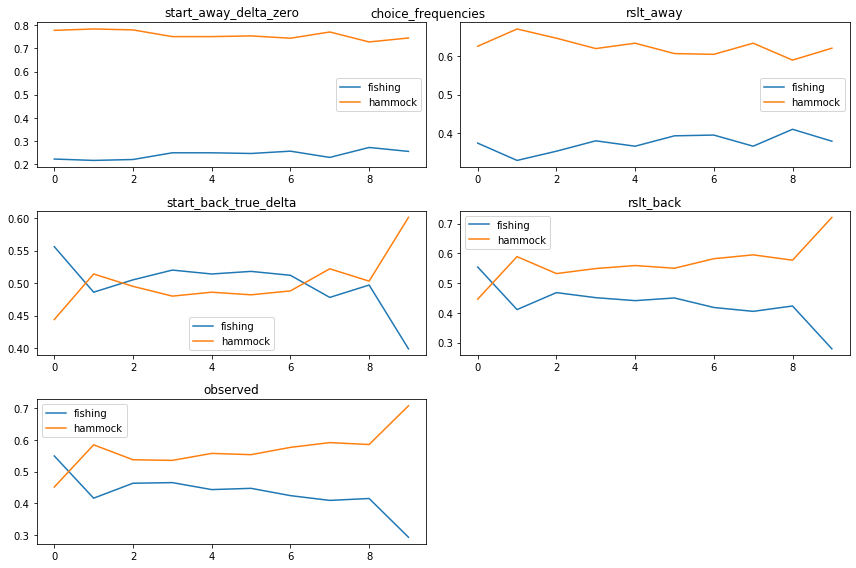

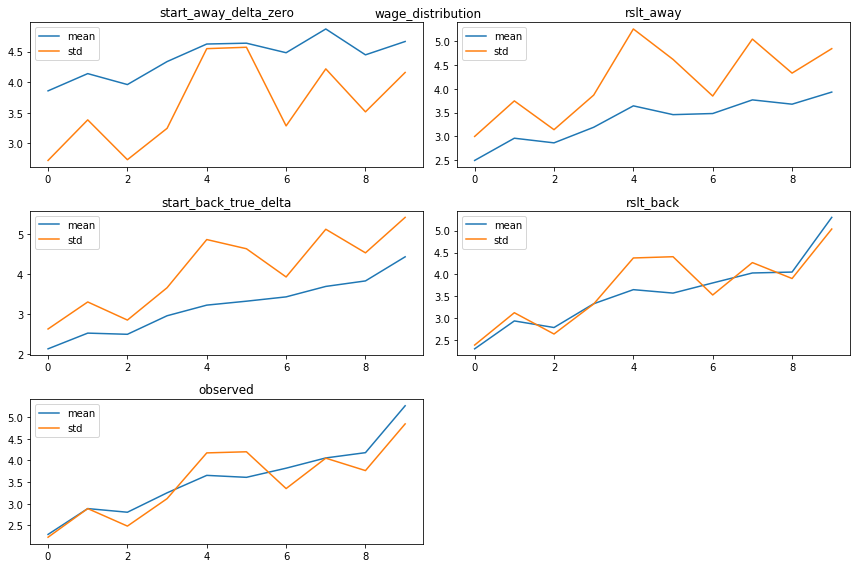

In [26]:
plot_moments(
    msm_inputs["empirical_moments"],
    simulated_moments=simulated_moments,
)

### Difference in moments result & observed

In [27]:
diff_choices = msm_inputs["empirical_moments"]["choice_frequencies"] - replace_nans(
    simulated_moments["choice_frequencies"]["rslt_back"])

In [28]:
diff_wages = (msm_inputs["empirical_moments"]["wage_distribution"] - replace_nans(
    simulated_moments["wage_distribution"]["rslt_back"]))/msm_inputs["empirical_moments"]["wage_distribution"] 

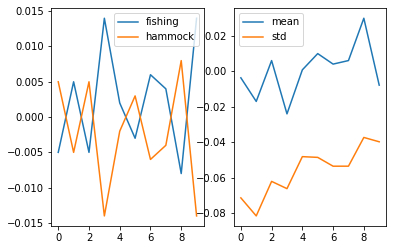

In [29]:
for idx, diff in enumerate([diff_choices, diff_wages]):
    plt.subplot(1,2,idx+1)
    plt.plot(diff)
    plt.legend(diff.columns,loc="best")

### Criterion History

In [30]:
def plot_criterion_history(db_path, iterations):
    """Plot criterion history."""
    database = load_database(db_path)
    criterion_history = read_last_iterations(
        database, "criterion_history", iterations, "pandas")
    plt.plot(criterion_history, alpha=0.5)
    plt.xlabel("Iterations")
    plt.ylabel("Criterion")
    plt.ylim(0,100000)
    plt.show()

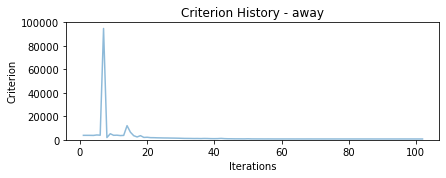

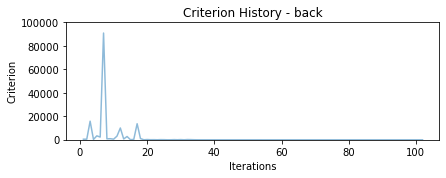

In [31]:
# Plot criterion history.
for idx, db in enumerate(["away", "back"]):
    plt.subplot(2,1, idx+1)
    plt.tight_layout()
    plt.title("Criterion History - "+ db)
    plot_criterion_history(
        db_path=logging_path + "/logging_" + db + ".db",
        iterations=10000,
    )

##  Maximum Likelihood

In [32]:
ml_criterion = rp.get_crit_func(params, options, data_obs)

In [33]:
logging_path_ml = create_logging_path("/logging/")
params_dict_ml = delta_exercise(
                                params_true=params,
                                criterion=ml_criterion,
                                optim_config=optim_config,
                                logging_path=logging_path_ml,
                                eval_away=100,
                                eval_back=100,
                            )

/home/anmearge/Documents/Econ/thesis/respy/respy/conditional_draws.py:70: RuntimeWarning: divide by zero encountered in update_mean_and_evaluate_likelihood
  log_wage_observed, log_wage_systematic, cov, choices, meas_sds
/home/anmearge/Documents/Econ/thesis/respy/respy/conditional_draws.py:70: RuntimeWarning: invalid value encountered in update_mean_and_evaluate_likelihood
  log_wage_observed, log_wage_systematic, cov, choices, meas_sds
/home/anmearge/Documents/Econ/thesis/respy/respy/conditional_draws.py:265: RuntimeWarning: invalid value encountered in true_divide
  updated_reduced_cov = reduced_cov - np.outer(f, f) / choice_var
/home/anmearge/Documents/Econ/thesis/respy/respy/conditional_draws.py:82: RuntimeWarning: invalid value encountered in calculate_conditional_draws
  base_draws, updated_means, updated_chols, chol_indices, MAX_LOG_FLOAT
/home/anmearge/Documents/Econ/thesis/respy/respy/likelihood.py:282: RuntimeWarning: invalid value encountered in _simulate_log_probability_of_

ValueError: Unable to coerce to Series, length must be 14: given 7

In [ ]:
simulated_moments_ml = get_simulated_moments(
    msm_inputs=msm_inputs, params_dict=params_dict_ml
)

In [ ]:
plot_moments(
    msm_inputs["empirical_moments"],
    simulated_moments=simulated_moments_ml,
)

In [ ]:
dd